## Cargar datos

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# statsmodels
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('once')

In [ ]:
serie_GWh = pd.read_csv('../data/datos_Oferta_Renovables_EU27_GWh.csv', index_col=0, parse_dates=True)['EU27']
# poner el índice con frecuencia diaria
serie_GWh = serie_GWh.asfreq('D')

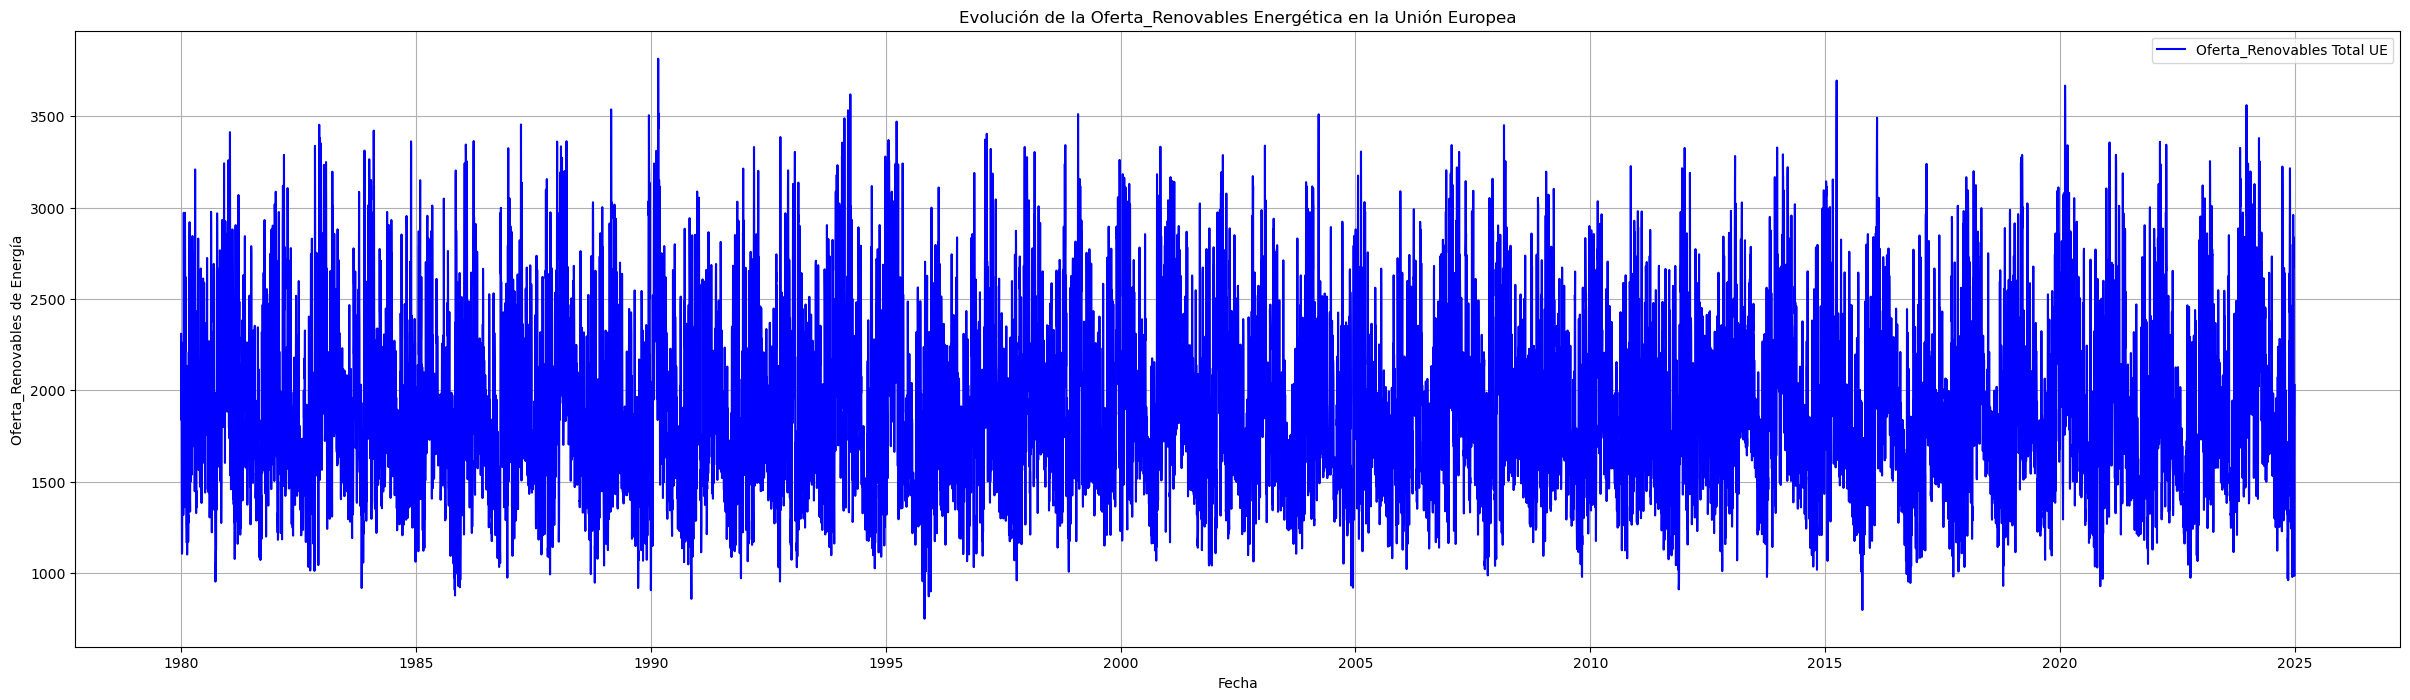

In [4]:
# Crear la figura y el gráfico
plt.figure(figsize=(30, 8))
plt.plot(serie_GWh.index, serie_GWh.values, label="Oferta_Renovables Total UE", color="blue")

# Etiquetas y título
plt.xlabel("Fecha")
plt.ylabel("Oferta_Renovables de Energía")
plt.title("Evolución de la Oferta_Renovables Energética en la Unión Europea")
plt.legend()
plt.grid()

# Mostrar el gráfico
plt.show()

## Características Serie Temporal Oferta

### Estacionariedad de la serie
La serie es estacionaria, por lo que ``d=0``, ``D=0``.

#### KPSS

In [6]:
from pmdarima.arima.utils import ndiffs

# Calcular el número óptimo de diferenciaciones con el test de KPSS
d_optimo = ndiffs(serie_GWh, test='kpss')
print(f"Valor óptimo de d según KPSS: {d_optimo}")

Valor óptimo de d según KPSS: 0


#### ADF
ADF (Augmented Dickey-Fuller) test is a statistical significance test which means the test will give results in hypothesis tests with null and alternative hypotheses. As a result, we will have a p-value from which we will need to make inferences about the time serie_GWhs, whether it is stationary or not.

In [9]:
from statsmodels.tsa.stattools import adfuller

# Aplicar la prueba de Dickey-Fuller Aumentado
result = adfuller(serie_GWh)

# Mostrar resultados
print(f"Estadístico de prueba ADF: {result[0]}")
print(f"p-valor: {result[1]}")

# Ver si la serie es estacionaria
if result[1] < 0.05:
    print("La serie es estacionaria (no necesita diferenciación, d=0).")
else:
    print("La serie no es estacionaria (se recomienda diferenciación, d=1).")

Estadístico de prueba ADF: -13.040054406829917
p-valor: 2.2509251696775078e-24
La serie es estacionaria (no necesita diferenciación, d=0).


In [ ]:
# Estadísticas del test ADF
dftest = adfuller(serie_GWh, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -13.040054406829917
2. P-Value :  2.2509251696775078e-24
3. Num Of Lags :  39
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 16397
5. Critical Values :
	 1% :  -3.4307488732096902
	 5% :  -2.8617162858063607
	 10% :  -2.5668638324883712


### Autocorrelación
La autocorrelación se refiere al grado de correlación entre las mismas variables entre dos intervalos de tiempo sucesivos. Mide cómo la versión rezagada (lagged) del valor de una variable está relacionada con la versión original en una serie temporal.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

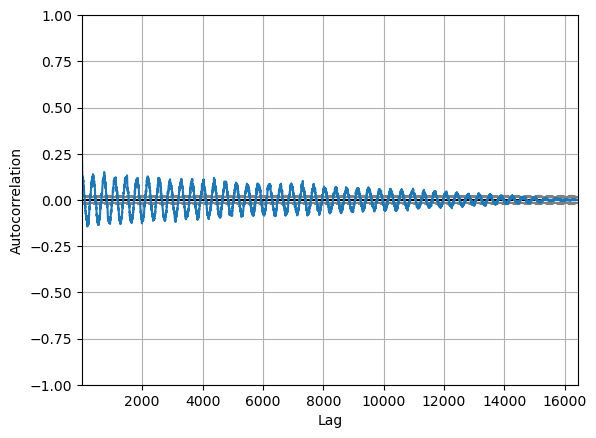

In [5]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(serie_GWh)

La autocorrelación es bastabte baja, con máximos sobre los 0.13, lo que indica que no hay una relación fuerte entre los valores de la serie temporal y sus versiones rezagadas.

#### ACF
El gráfico ACF (Autocorrelation Function) muestra la correlación entre una serie_GWh temporal y una versión rezagada de sí misma.   
  
En este caso, el gráfico ACF disminuye exponencialmente, pero de forma sinusoidal. Esto puede indicar que la serie_GWh temporal es estacional.

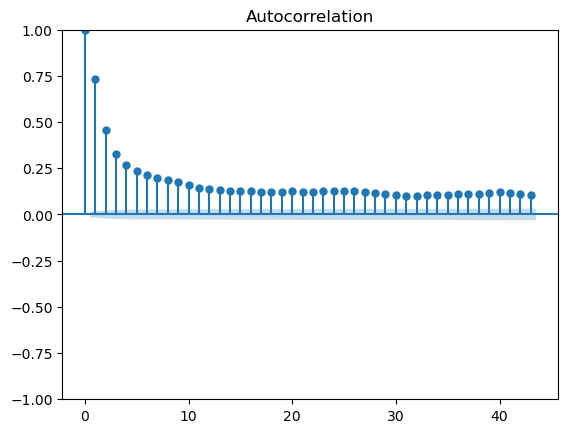

In [10]:
# solo con 50 lags
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(serie_GWh)
plt.show()

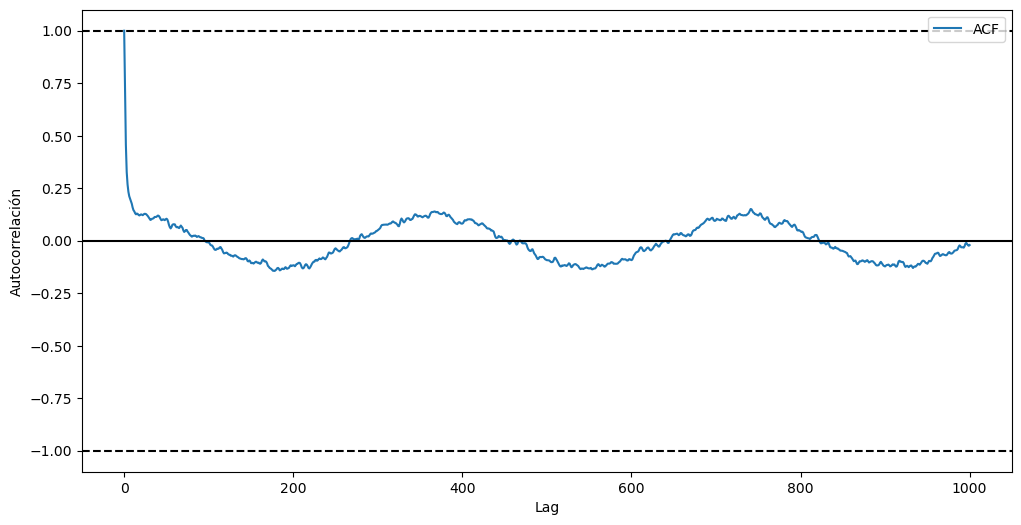

In [11]:
# con 1000 lags
from statsmodels.tsa.stattools import acf

# Calcular ACF con más lags
acf_values = acf(serie_GWh, nlags=1000)

# Graficar la ACF
plt.figure(figsize=(12,6))
plt.plot(acf_values, label="ACF")

plt.xlabel("Lag")
plt.ylabel("Autocorrelación")
plt.axhline(y=0, color='black', linestyle='-')
plt.axhline(y=1, color='black', linestyle='--')
plt.axhline(y=-1, color='black', linestyle='--')
plt.legend()
plt.show()

Observaciones:

- Fuerte pico en el lag 0: Esto es típico en cualquier serie temporal, ya que la autocorrelación de una serie consigo misma en el mismo punto (lag=0) siempre es 1. Este pico está bien.

- Rápida caída a cero: Después del pico en el lag 0, la autocorrelación baja rápidamente a cero y no se observa correlación significativa en los primeros lags. Esto sugiere que no hay un componente autoregresivo fuerte a corto plazo (por ejemplo, no hay un p alto necesario en un modelo ARIMA).

- Patrón periódico: Hay una oscilación periódica después de la caída inicial, con picos positivos y negativos a intervalos regulares (cerca de los lags 364, 728, etc.), lo cual indica una posible estacionalidad anual. Este comportamiento puede ser interpretado como un componente estacional, y es consistente con la naturaleza de los datos de oferta renovable que suelen seguir patrones anuales debido a la variación estacional en la disponibilidad de energías renovables (como la eólica y la solar).

#### Periodicidad
Vamos a calcular el periodo estimado de la serie, usando la autocorrelación.  
  
Periodicidad anual. Valor estimado según los datos $m=376$.

Picos detectados en la ACF: [ 367  741 1121 1496]


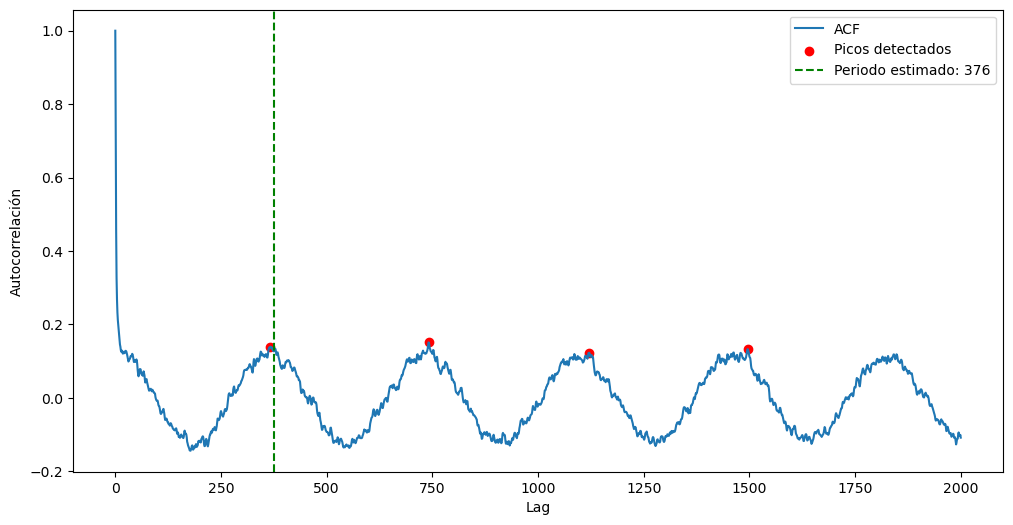

El período estacional estimado es aproximadamente 376 lags.


In [26]:
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

# Calcular ACF con más lags
acf_values = acf(serie_GWh, nlags=2000)

# Encontrar los picos con mejores criterios
peaks, _ = find_peaks(acf_values, height=0.12, distance=100, prominence=0.1)
print("Picos detectados en la ACF:", peaks)

# Calcular la distancia promedio entre picos significativos
peak_distances = np.diff(peaks)
periodo_estimado = int(np.mean(peak_distances)) if len(peak_distances) > 0 else None

# Graficar la ACF con los picos mejor detectados
plt.figure(figsize=(12,6))
plt.plot(acf_values, label="ACF")
plt.scatter(peaks, acf_values[peaks], color='red', label="Picos detectados")
if periodo_estimado:
    plt.axvline(periodo_estimado, color='green', linestyle='dashed', label=f'Periodo estimado: {periodo_estimado}')

plt.xlabel("Lag")
plt.ylabel("Autocorrelación")
plt.legend()
plt.show()

print(f"El período estacional estimado es aproximadamente {periodo_estimado} lags.")


La serie temporal de la oferta diaria de energía renovable parece tener una estacionalidad anual (aproximadamente cada 376 días). Esto es consistente con las fluctuaciones estacionales que afectan la oferta de energías renovables, como la eólica y la solar.

#### PACF
El gráfico PACF (Partial Autocorrelation Function) muestra la correlación entre una serie temporal y una versión rezagada de sí misma después de eliminar los efectos de las observaciones intermedias.

En este caso, se puede ver una fuerte correlación con los primeros lags y luego un drástico desplome. Eso significa que **la parte AR de la serie_GWh temporal, tendrá un orden bajo** (menor de 10 seguro).

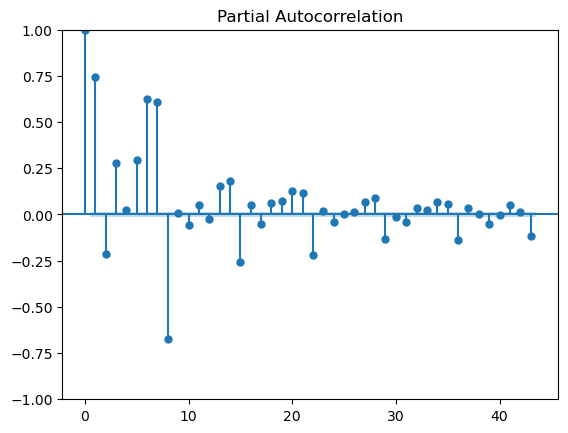

In [35]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(serie_GWh)
plt.show()

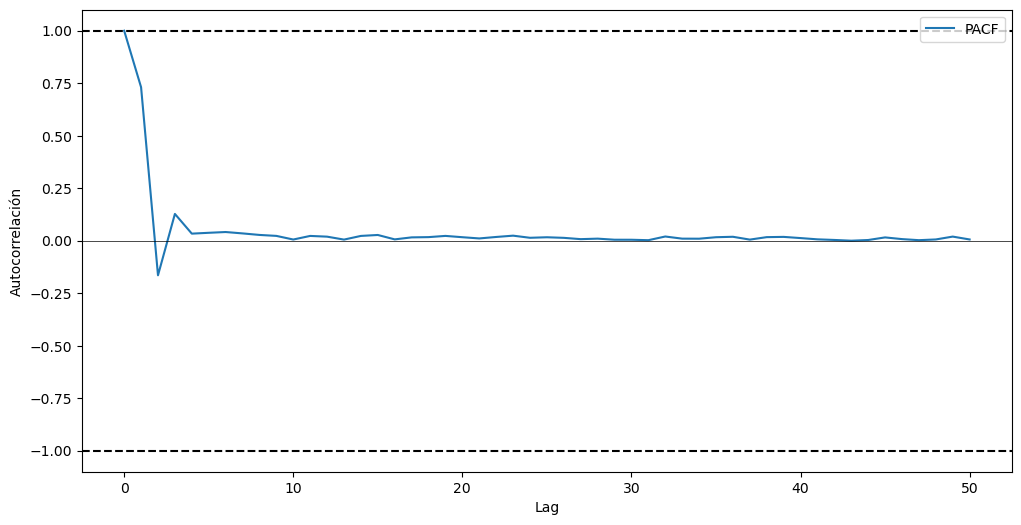

In [ ]:
# con 50 lags
from statsmodels.tsa.stattools import pacf

# Calcular ACF con más lags
pacf_values = pacf(serie_GWh, nlags=50)

# Graficar la PACF
plt.figure(figsize=(12,6))
plt.plot(pacf_values, label="PACF")

plt.xlabel("Lag")
plt.ylabel("Autocorrelación")
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.axhline(y=1, color='black', linestyle='--')
plt.axhline(y=-1, color='black', linestyle='--')
plt.legend()
plt.show()

Observaciones:
- Pico en el lag 1: la autocorrelación parcial es significativa en el primer lag, lo que indica que el valor de la serie temporal en lag 1 está correlacionado de manera importante con el valor en el momento actual.
Este comportamiento sugiere que p=1 es un valor adecuado para el componente AR (AutoRegresivo), ya que el primer lag es el que muestra la mayor correlación. Esto indica que el modelo ARIMA podría tener un término autoregresivo de orden 1.

- Después del primer pico, los valores de la PACF se mantienen cercanos a 0 sin más picos significativos. Esto sugiere que no hay dependencia significativa en lags mayores a 1, lo que implica que no es necesario incluir términos AR adicionales (es decir, no se requiere un valor alto para p).

### prueba ranking lags ACF y PACF

Lags significativos en PACF (para p): 0      1.000000
1      0.730844
2      0.164654
3      0.127538
6      0.041404
5      0.037721
7      0.034806
4      0.033725
438    0.027631
8      0.027552
dtype: float64

Lags significativos en ACF (para q): 0    1.000000
1    0.730844
2    0.457426
3    0.326821
4    0.268319
5    0.232920
6    0.211778
7    0.199135
8    0.188033
9    0.176215
dtype: float64


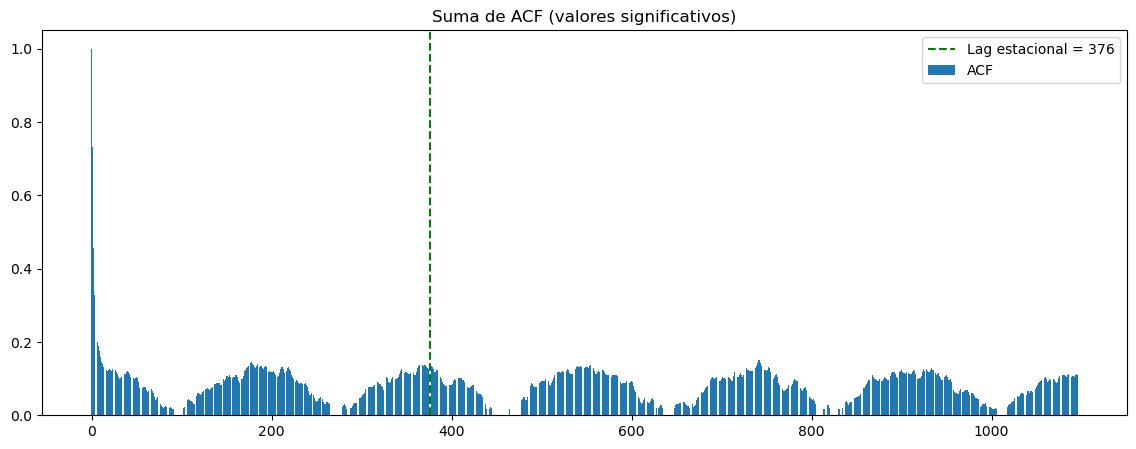

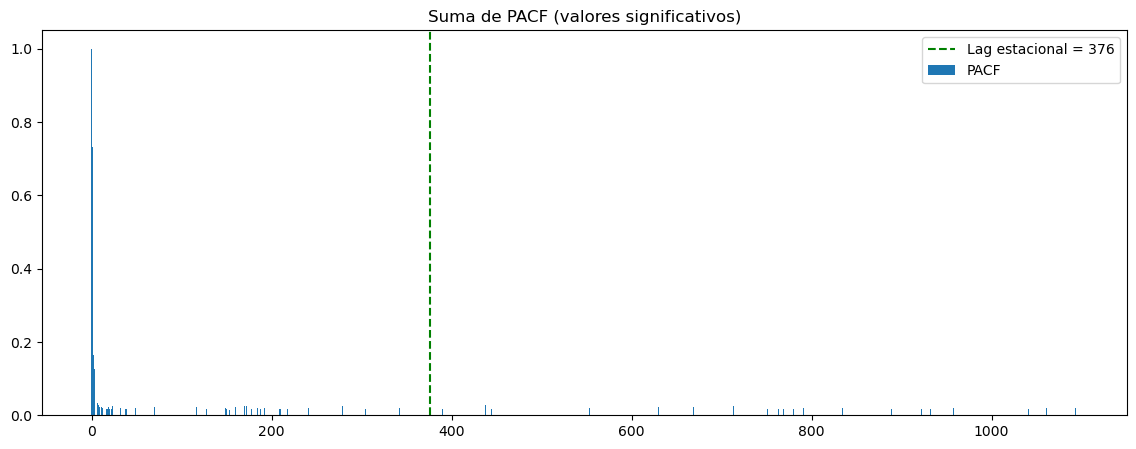

In [37]:
from statsmodels.tsa.stattools import acf, pacf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Definir parámetros: mirar 3 años
max_lag = 365 * 3
PERIODO_ESTIMADO = 376


# Calcular ACF y PACF
acf_vals = acf(serie_GWh, nlags=max_lag)
pacf_vals = pacf(serie_GWh, nlags=max_lag, method='ywm')

# Calcular umbrales de significancia (95% CI)
conf_int = 1.96 / np.sqrt(len(serie_GWh))
significant_acf = np.where(np.abs(acf_vals) > conf_int, np.abs(acf_vals), 0)
significant_pacf = np.where(np.abs(pacf_vals) > conf_int, np.abs(pacf_vals), 0)

# Sumar por lag (para ranking)
acf_sum = pd.Series(significant_acf).sort_values(ascending=False)
pacf_sum = pd.Series(significant_pacf).sort_values(ascending=False)


# Mostrar top lags para p y q
print("Lags significativos en PACF (para p):", pacf_sum.head(10))
print()
print("Lags significativos en ACF (para q):", acf_sum.head(10))


# Graficar
plt.figure(figsize=(14,5))
plt.bar(range(len(significant_acf)), significant_acf, label="ACF")
plt.axvline(x=PERIODO_ESTIMADO, color='green', linestyle='--', label=f'Lag estacional = {PERIODO_ESTIMADO}')
plt.title("Suma de ACF (valores significativos)")
plt.legend()
plt.show()

plt.figure(figsize=(14,5))
plt.bar(range(len(significant_pacf)), significant_pacf, label="PACF")
plt.axvline(x=PERIODO_ESTIMADO, color='green', linestyle='--', label=f'Lag estacional = {PERIODO_ESTIMADO}')
plt.title("Suma de PACF (valores significativos)")
plt.legend()
plt.show()


#### p, q

Interpretación resultados PACF:
- Lag 1: Tiene una autocorrelación de 0.730844, lo que indica que el valor de la serie en el primer lag está significativamente correlacionado con el valor actual.

- A partir de los Lag 2 y 3 tienen una autocorrelación baja 0.164654, 0.127538... y el resto ya por debajo de 1.

**Conclusión: valor de**  ``p~1``   
Dado que lag 1 es el más significativo en la PACF, un modelo AR(1) podría ser apropiado.   
También se podrían considerar valores pequeños de p (1 o 2), ya que los otros lags significativos tienen autocorrelaciones más bajas.

Interpretación resultados ACF:
- Lag 1: tiene una autocorrelación significativa de 0.730844

- A partir de los Lag 2 y 3 tienen una autocorrelación menor (0.457426 y 0.326821), el resto ya se desploma.

**Conclusión: valor de**  ``q~1``    
Al igual que con p, q parece tener un valor adecuado de 1 o 2 debido a las significativas autocorrelaciones en los primeros lags (hasta el lag 3).

#### P, Q
- ``P=1``: es una opción lógica, ya que la PACF muestra un pico significativo en lag 1, lo que indica un componente autoregresivo estacional. No parece haber una dependencia fuerte a largo plazo (más allá de lag 438), lo que significa que no es necesario agregar más términos AR estacionales.

- ``Q=1``: Los picos significativos en la ACF en lags 0-9 y 741-743 sugieren que un Q=1 o Q=2 puede ser adecuado para capturar la estacionalidad a largo plazo. Además, la ACF tiene varios picos dispersos, lo que indica que podría haber fluctuaciones de larga duración que el modelo MA debe capturar. Es posible que probando Q=2 se logre un mejor ajuste, pero también podría ser útil probar Q=1 primero.



In [ ]:
# ver el ranking de lags significativos en una lista ordenada
acf_sum.head(20)

0      1.000000
1      0.730844
2      0.457426
3      0.326821
4      0.268319
5      0.232920
6      0.211778
7      0.199135
8      0.188033
9      0.176215
10     0.158285
741    0.151087
742    0.149561
11     0.145470
178    0.143986
176    0.143180
177    0.143113
740    0.142881
743    0.141990
184    0.141140
dtype: float64

In [40]:
pacf_sum.head(20)

0      1.000000
1      0.730844
2      0.164654
3      0.127538
6      0.041404
5      0.037721
7      0.034806
4      0.033725
438    0.027631
8      0.027552
15     0.027319
170    0.025513
172    0.025175
713    0.024972
279    0.024057
23     0.024046
117    0.023463
9      0.022992
19     0.022894
14     0.022847
dtype: float64

### Descomposición
Está claro que hay una estacionalidad relacionada con el momento del año.

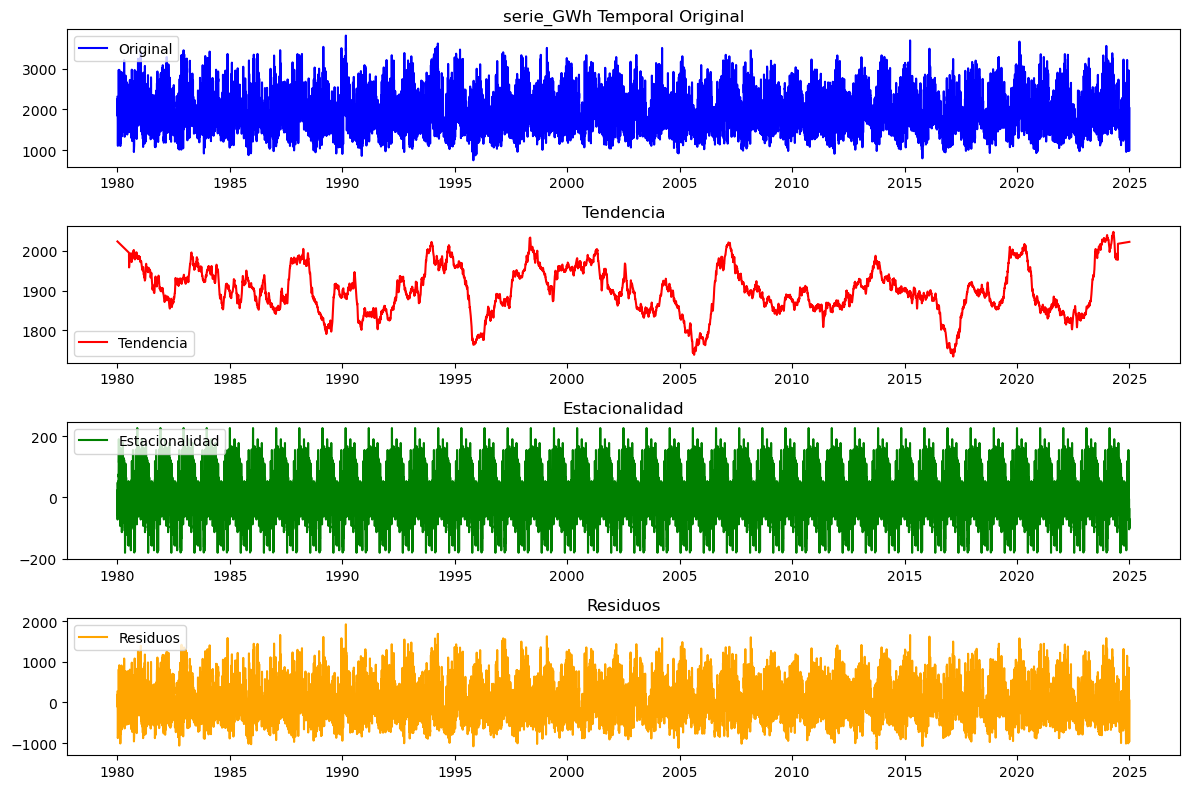

In [38]:
serie_GWh_descomp = seasonal_decompose(serie_GWh, model='additive', extrapolate_trend='freq', period=PERIODO_ESTIMADO)

# Obtención de las componentes
trend = serie_GWh_descomp.trend
seasonal = serie_GWh_descomp.seasonal
residuals = serie_GWh_descomp.resid

# Graficar las componentes
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(serie_GWh, label='Original', color='blue')
plt.legend()
plt.title('serie_GWh Temporal Original')

plt.subplot(412)
plt.plot(trend, label='Tendencia', color='red')
plt.legend()
plt.title('Tendencia')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad', color='green')
plt.legend()
plt.title('Estacionalidad')

plt.subplot(414)
plt.plot(residuals, label='Residuos', color='orange')
plt.legend()
plt.title('Residuos')

plt.tight_layout()
plt.show()

## FINDINGS
- ```d=0``` :  serie estacionaria según test ADF y KPSS
- ```D=0```
- ```m=376``` : estacionalidad anual, estimación según los datos.
- ```p``` : por el PACF vemos que el lag más significativo es ```1```, un poco ```[2, 3]```.
- ```q``` : por el ACF vemos que el lag más significativo es ```1```, algo significativos también son ```[2, 3]```.
- ```P``` : en la gráfica del PACF vemos un pico relevante en $364$ por lo tanto ```1```
- ```Q``` : por el ACF vemos que los lags (estacionales $+364$) más significativos son $364, 371, 728$, por lo tanto ```[1,2]```

